In [1]:
# Import various dependencies, including the relevant modules from the Perch
# repository. Note that "chirp" is the old name that the Perch team used, so any
# chirp modules imported here were installed as part of the Perch repository in
# one of the previous cells.

import collections
from etils import epath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import shutil
import tensorflow as tf
from tqdm import tqdm
import os
import json
import pathlib
import seaborn as sns

2025-04-03 08:27:51.716962: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 08:27:51.732834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743668871.750813 2662180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743668871.756684 2662180 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 08:27:51.777240: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
path_to_working_dir = pathlib.Path('/mnt/fscompute_shared/agile_modeling/experiments_paper/output')
datasets_to_include = ['grafton_deployment', 'texel']

In [5]:
final_results = pd.DataFrame(columns=['sound_name', 'model', 'picking_strategy', 'ratio', 'n_samples', 'split', 'value', 'metric'])
metrics = ['precision', 'recall', 'auc_roc', 'auc_pr']
for dataset_name in datasets_to_include:
    dataset_folder = path_to_working_dir.joinpath(dataset_name)
    for model_folder in dataset_folder.glob('*'): 
        if model_folder.is_dir(): 
            results_folder = model_folder.joinpath('results')
            if results_folder.exists(): 
                for results_json in results_folder.glob('*'): 
                    if not results_json.is_dir():
                        sound_name, model_name, strategy, ratio, _ = results_json.name.split('_')
                        df_results = pd.read_json(str(results_json))
                        for n_samples in df_results.columns: 
                            for split in df_results.index: 
                                results = df_results.loc[split][n_samples]
                                for metric in metrics: 
                                    
                                    df_i = pd.DataFrame({'sound_name': sound_name, 'model': model_name, 'picking_strategy': strategy, 'ratio': ratio, 
                                                     'n_samples': n_samples, 'split': split, 'value': results[metric], 'metric': metric})
                                
                                    if final_results is None:
                                        final_results = df_i
                                    else:
                                        final_results = pd.concat([final_results, df_i], ignore_index=True)

/tmp/ipykernel_2662180/142955972.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, df_i], ignore_index=True)


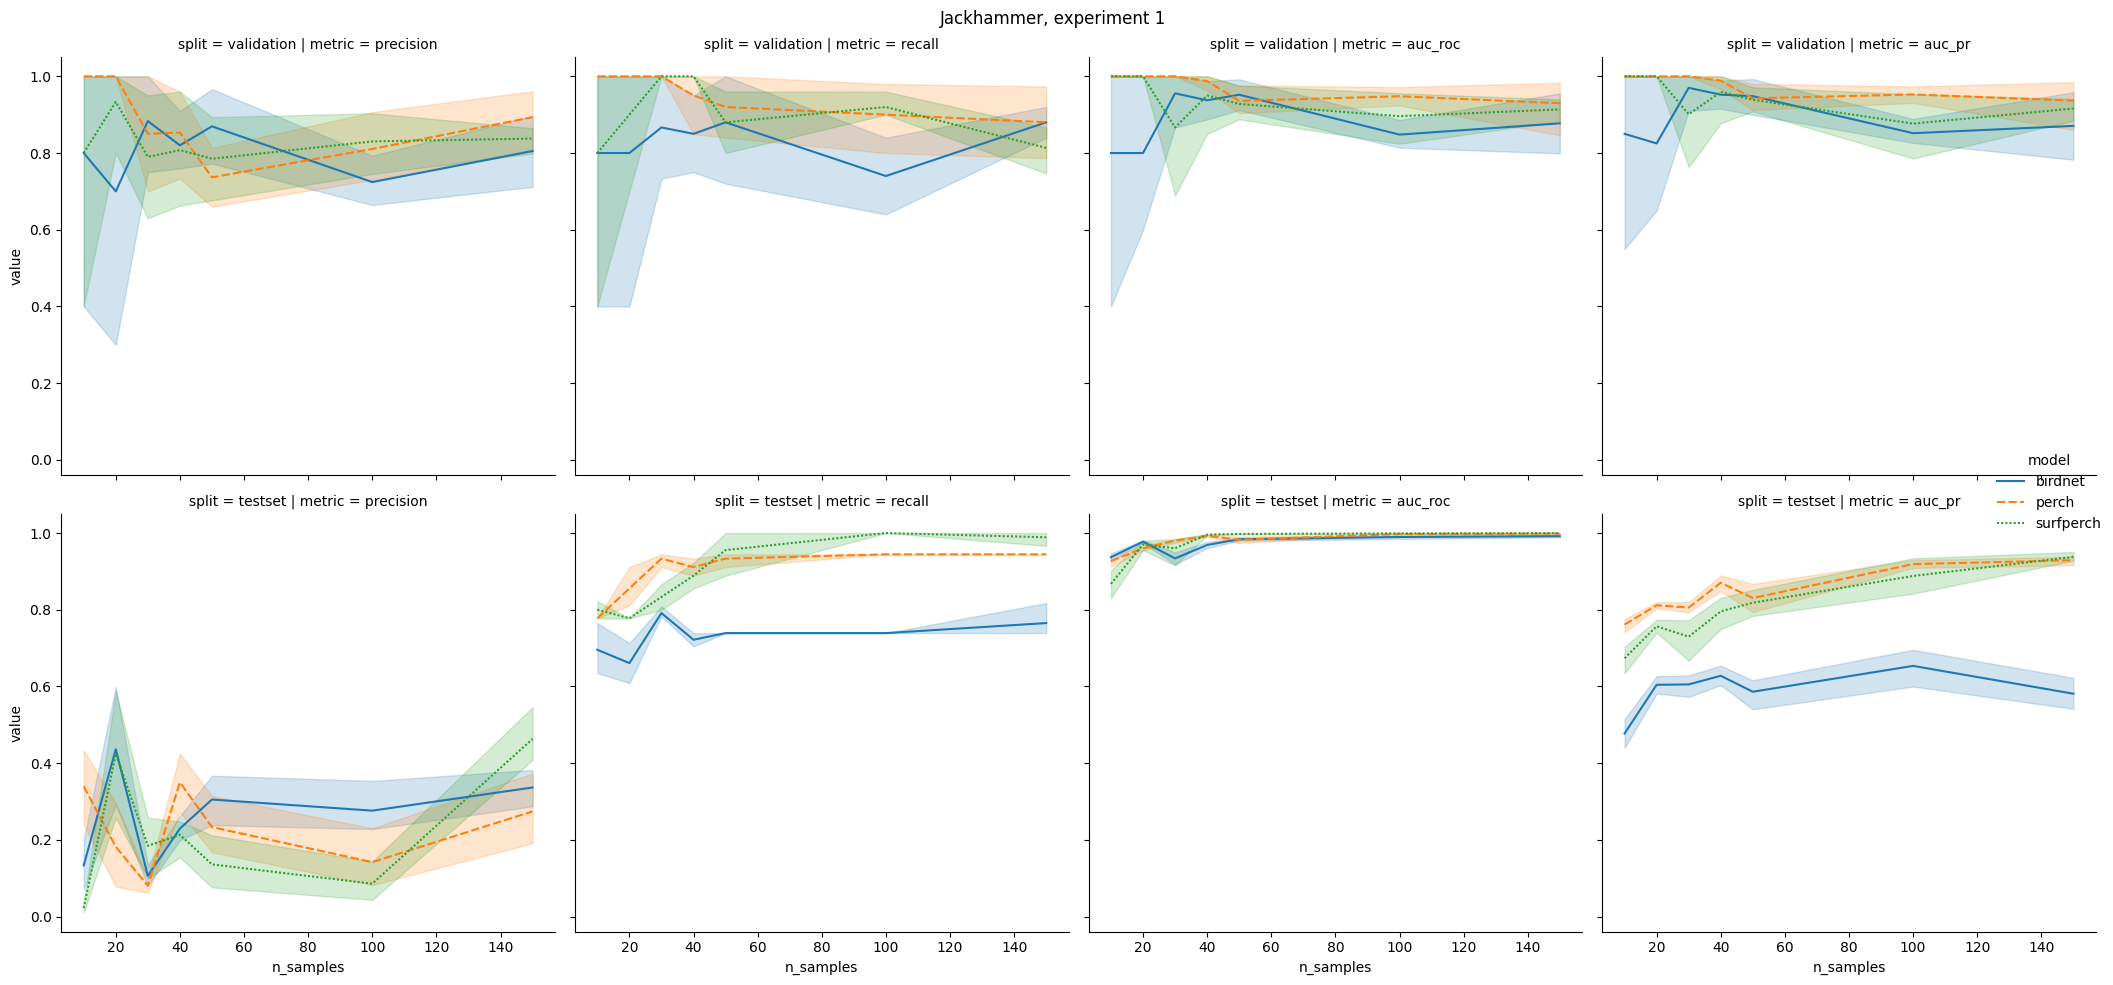

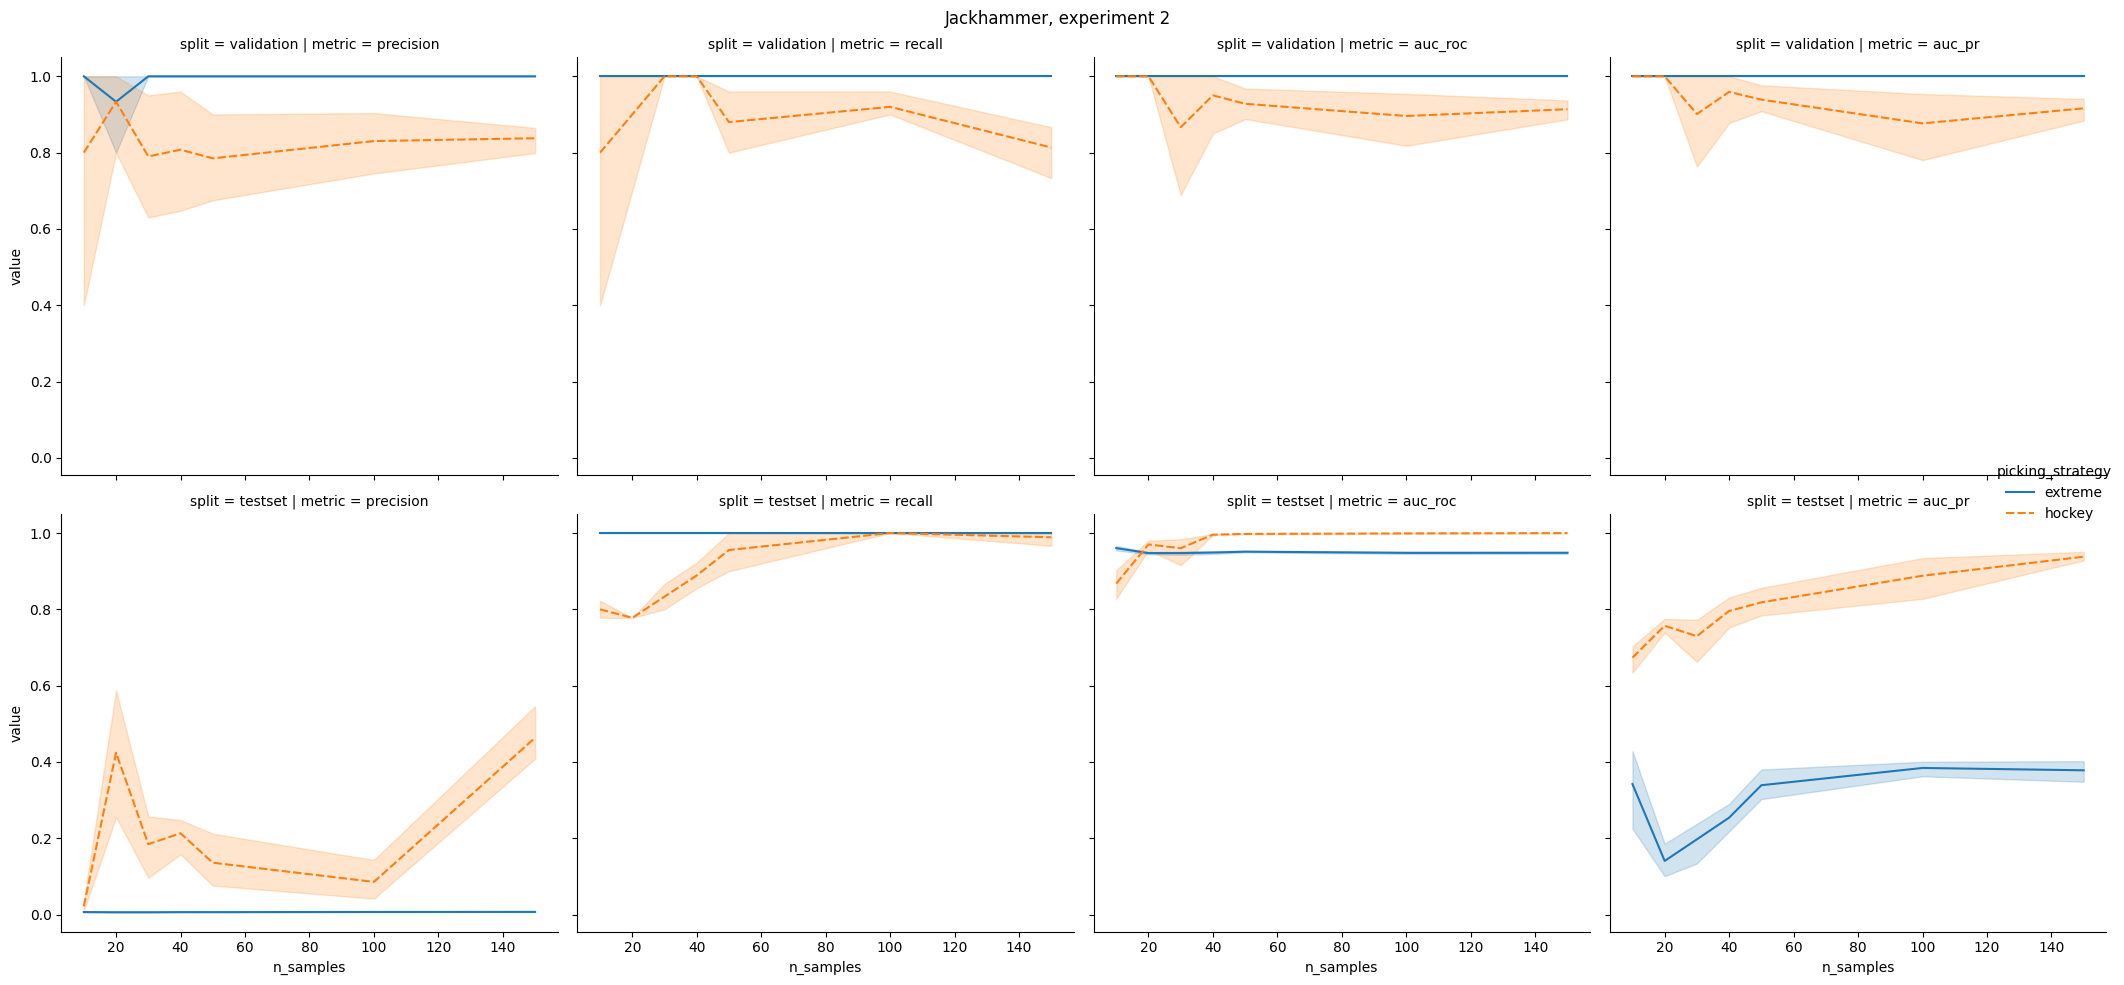

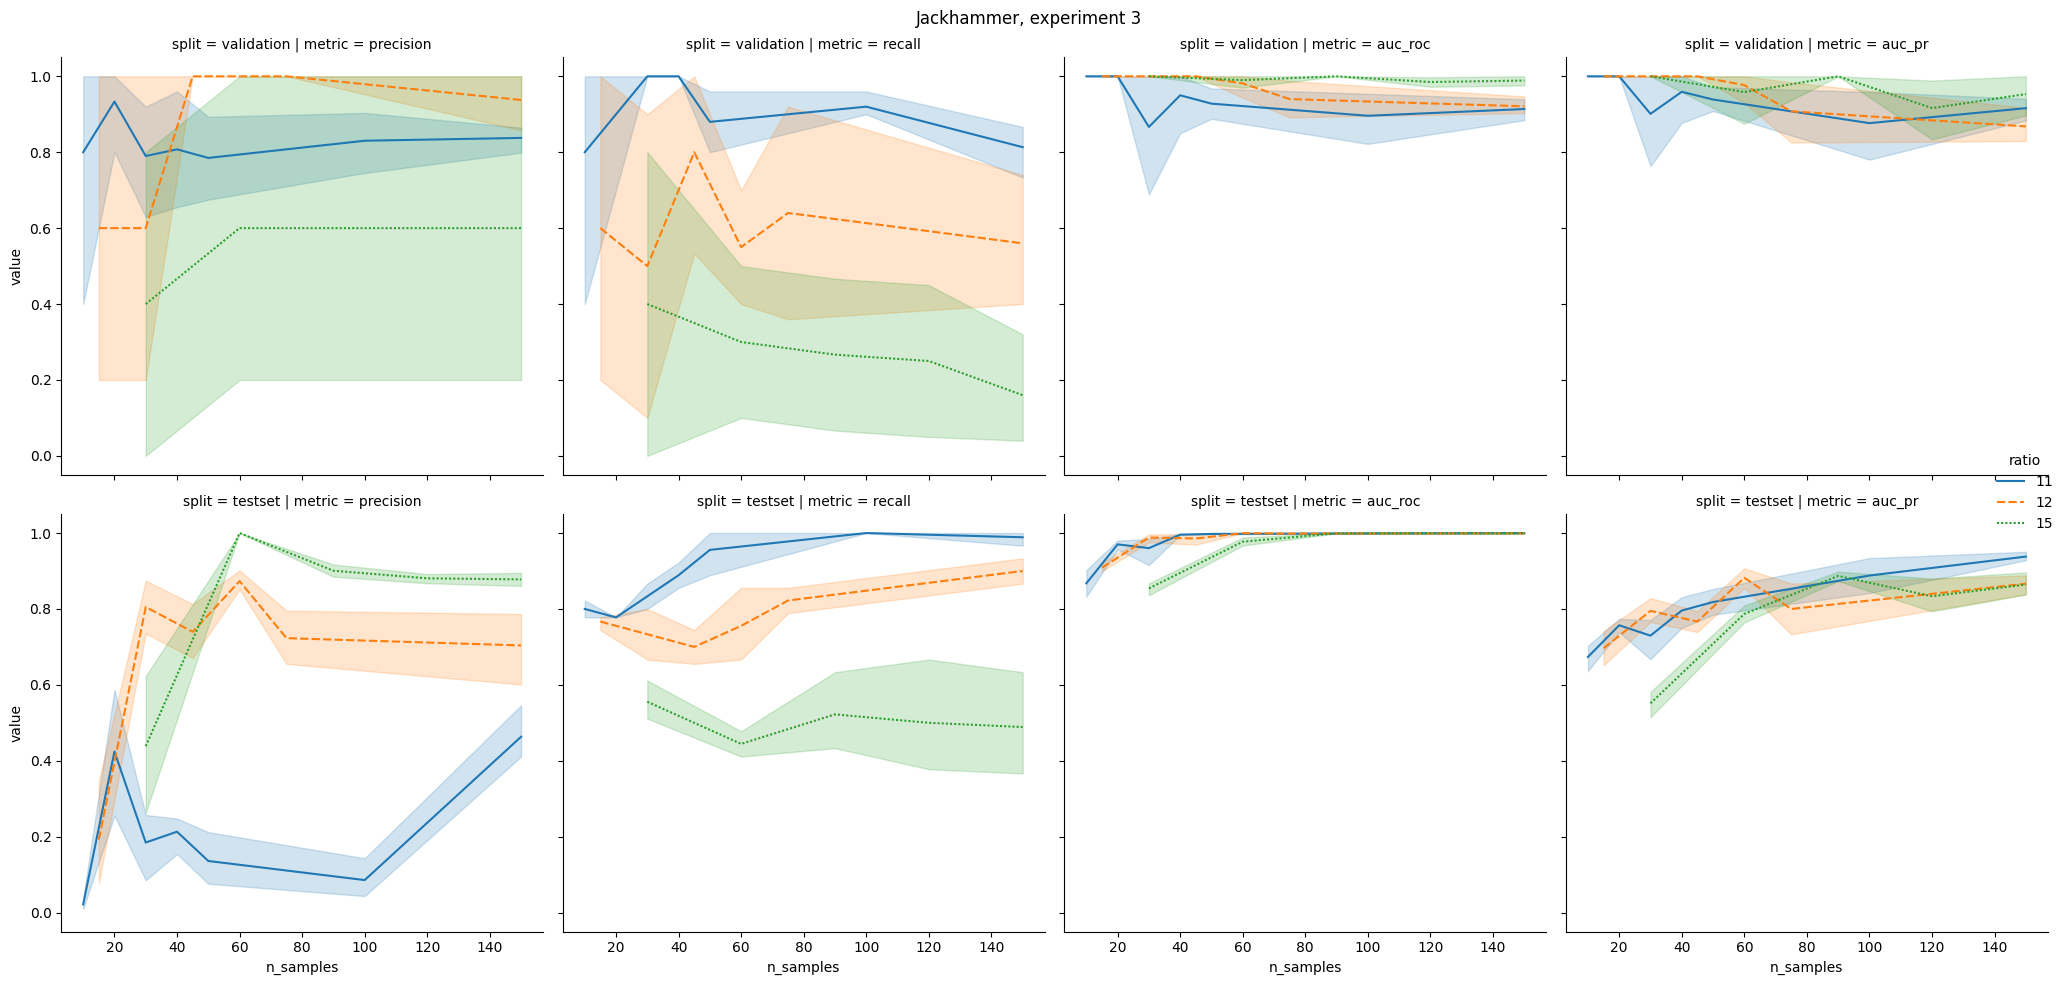

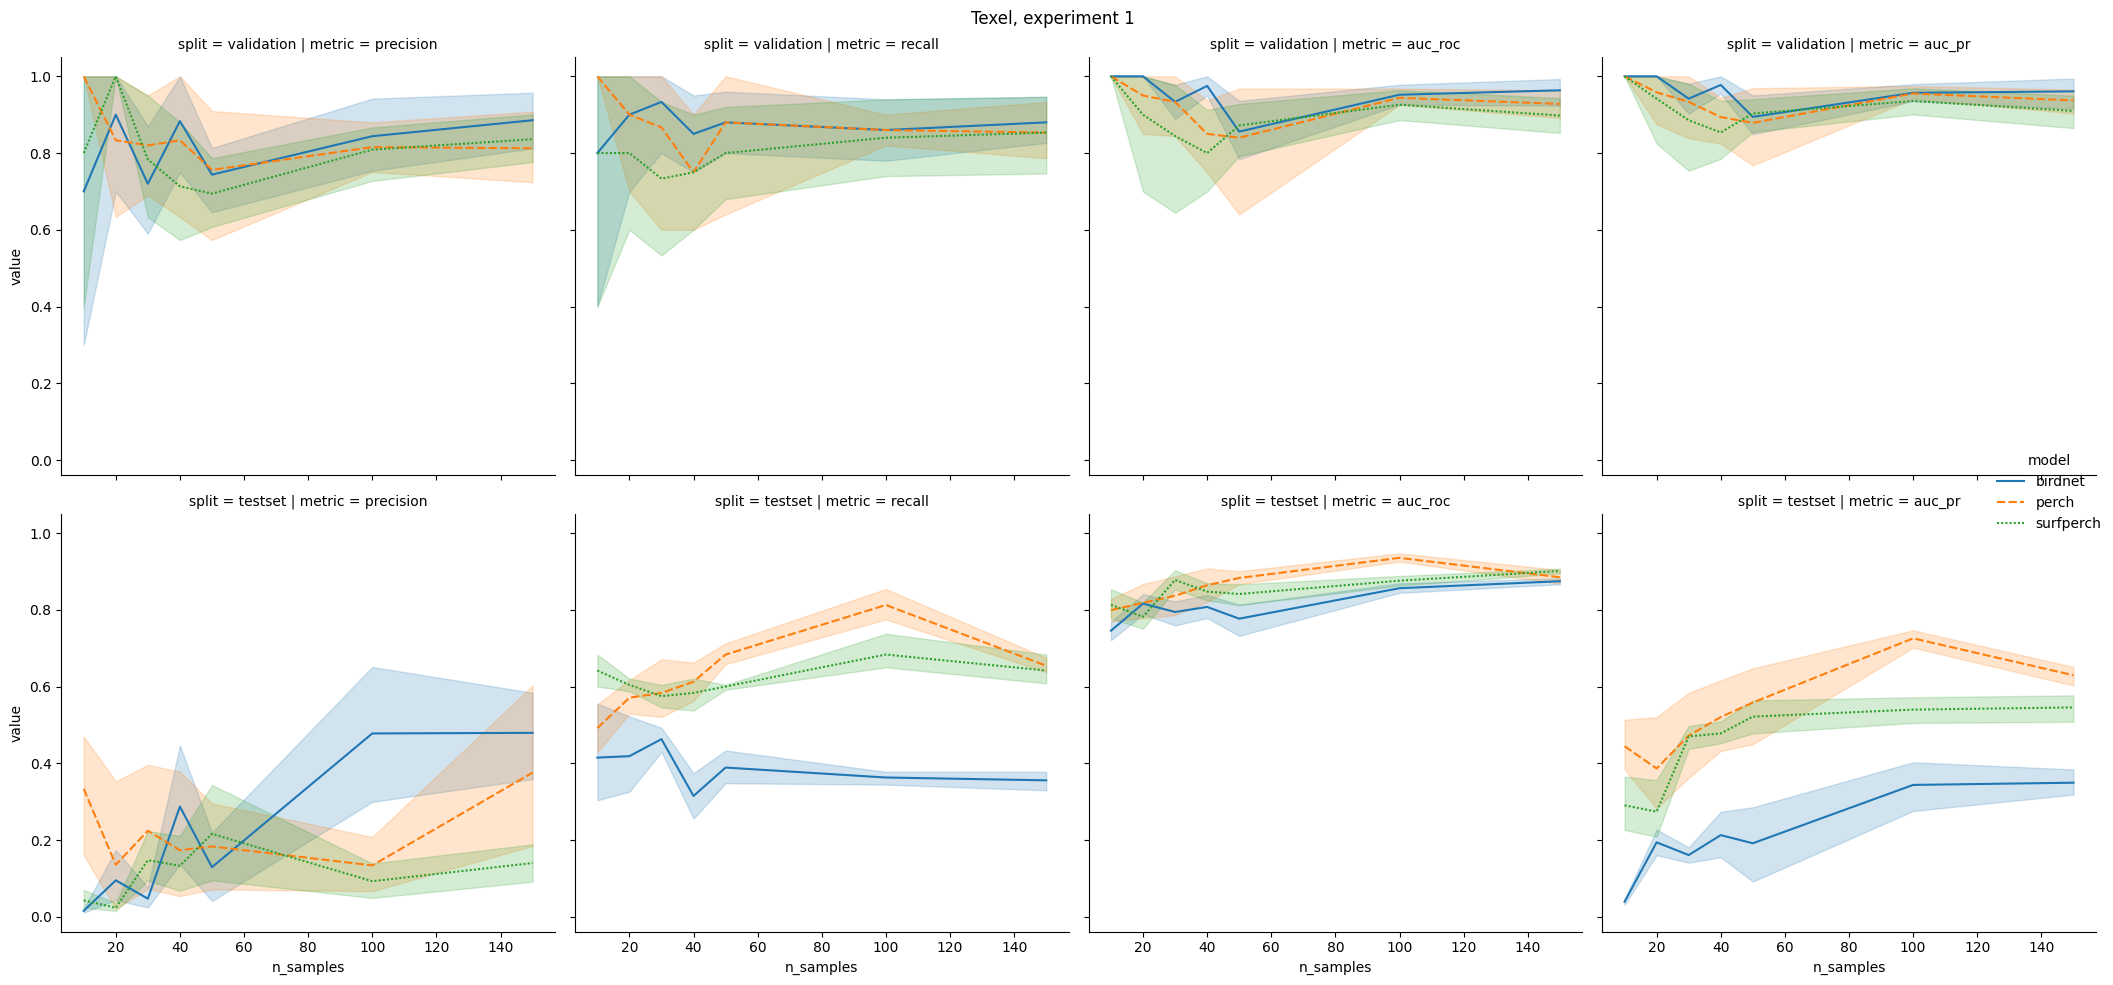

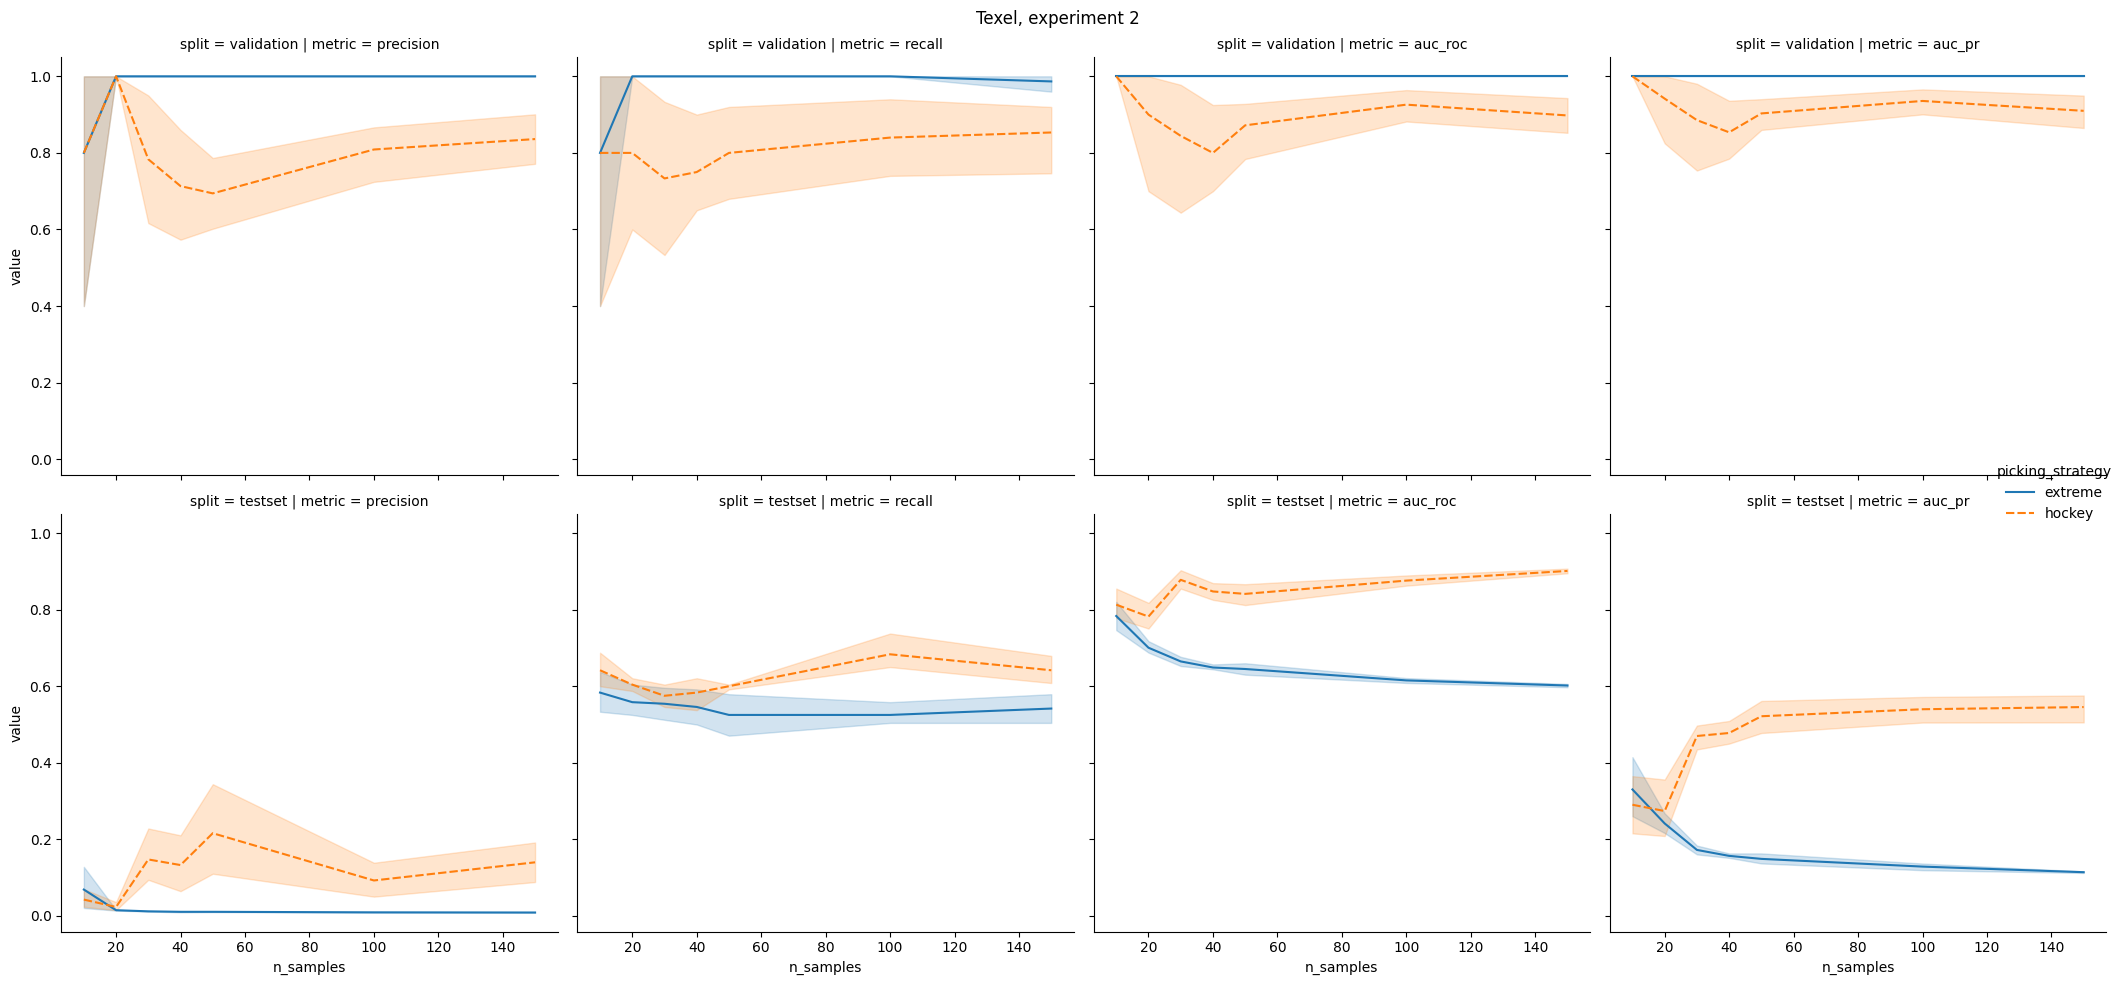

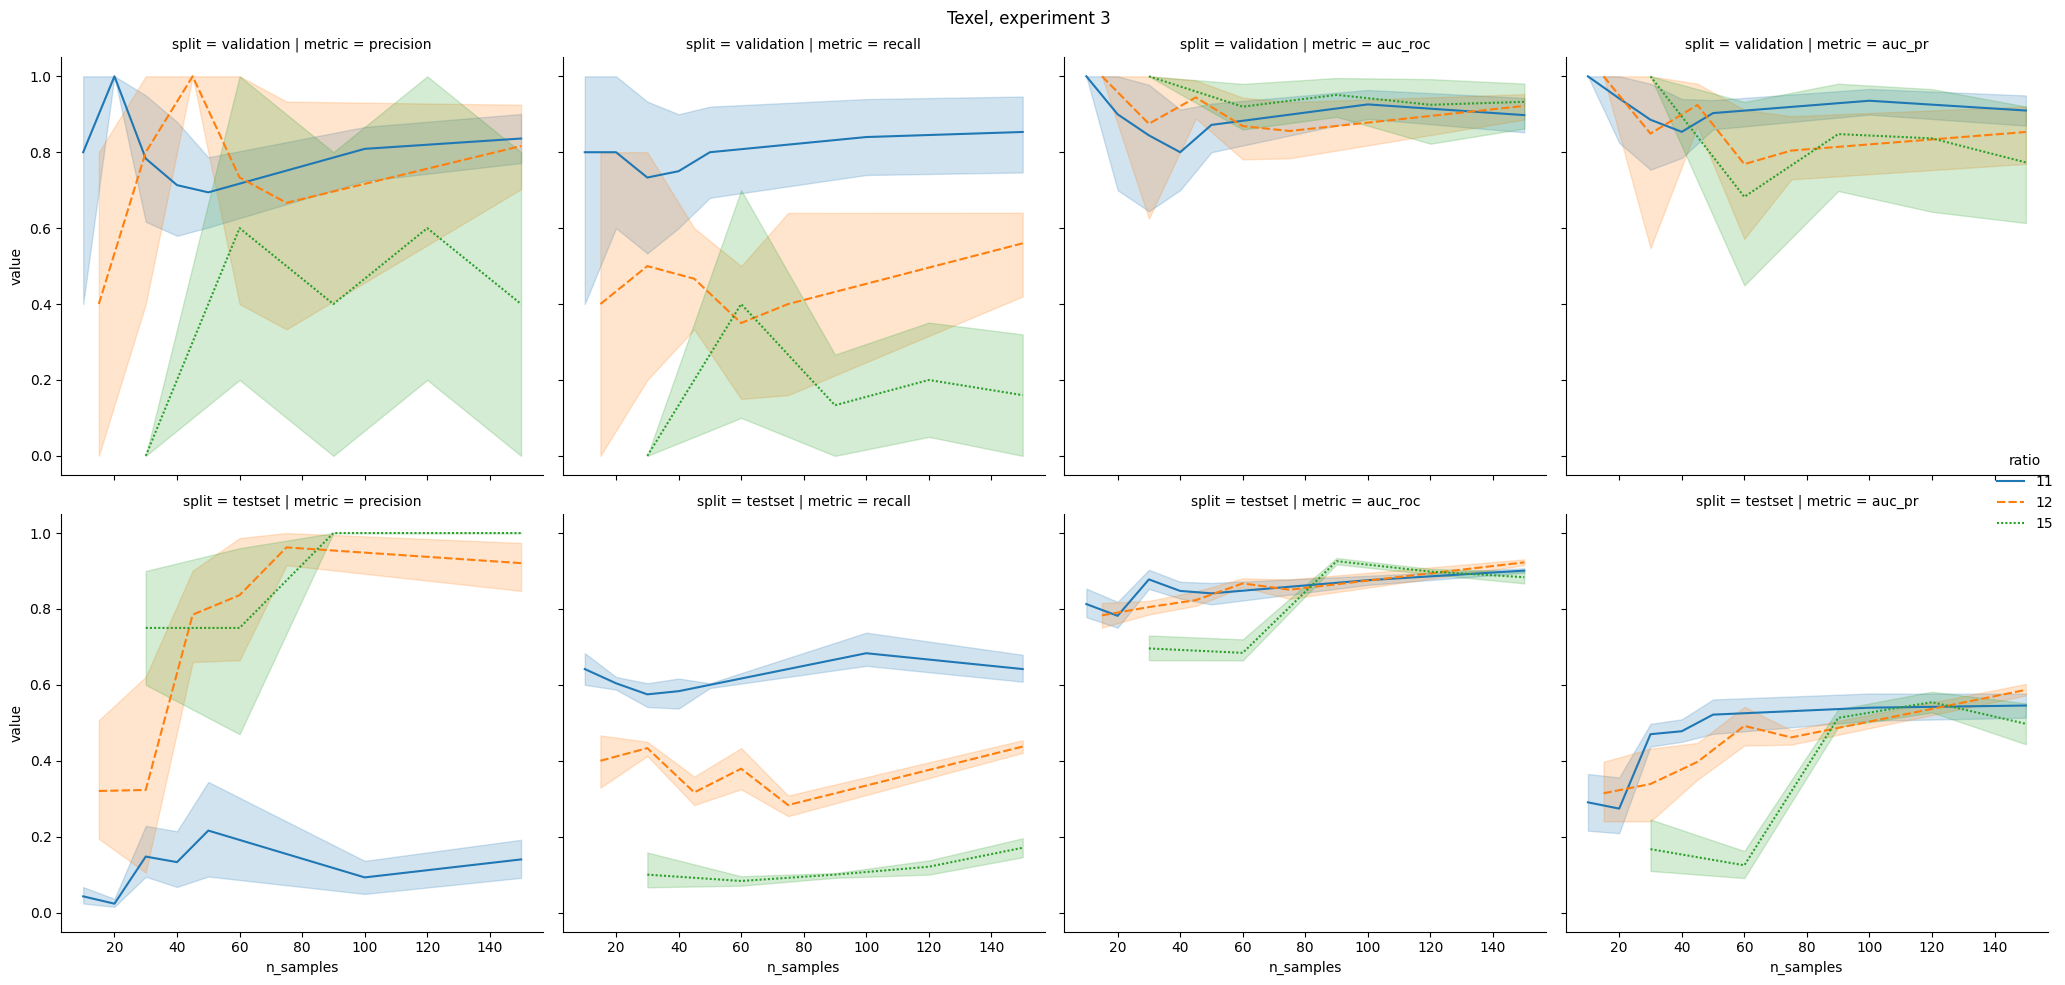

In [14]:
for sound_name, sound_results in final_results.groupby('sound_name'): 
    # Experiment 1: model 
    filtered_sound_results = sound_results.loc[(sound_results.ratio == '11') & (sound_results.picking_strategy == 'hockey')]
    sns.relplot(
        data=filtered_sound_results, style="model", row='split', x="n_samples", y="value", col="metric", hue="model", kind="line", row_order=["validation", "testset"]
    )
    plt.suptitle(f'{sound_name.capitalize()}, experiment 1')
    plt.tight_layout()
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp1.png'))
    plt.show()

    # Experiment 2: picking strategy
    filtered_sound_results = sound_results.loc[(sound_results.model == 'surfperch') & (sound_results.ratio == '11')]
    sns.relplot(
        data=filtered_sound_results, style="picking_strategy", row='split', x="n_samples", y="value", col="metric", hue="picking_strategy", kind="line", row_order=["validation", "testset"]
    )
    plt.suptitle(f'{sound_name.capitalize()}, experiment 2')
    plt.tight_layout()
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp2.png'))
    plt.show()

    # Experiment 2: picking strategy
    filtered_sound_results = sound_results.loc[(sound_results.model == 'surfperch') & (sound_results.picking_strategy == 'hockey')]
    sns.relplot(
        data=filtered_sound_results, style="ratio", row='split', x="n_samples", y="value", col="metric", hue="ratio", kind="line", row_order=["validation", "testset"]
    )
    plt.suptitle(f'{sound_name.capitalize()}, experiment 3')
    plt.tight_layout()
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp3.png'))
    plt.show()
